In [24]:
from __future__ import absolute_import, division, print_function, unicode_literals
from IPython.display import display, HTML
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json, sys, os

plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.max_open_warning'] = 50
display(HTML("<style>.container { width:100% !important; }</style>"))

sys.path.insert(0, os.getcwd() + "/../../")
from analysis.utils import PM_HOME, GPU_NAME
from analysis.trace_utils import *

In [25]:
# Global reuse_factor of all tables all batches
locality_file_path = "/nvme/deep-learning/dlrm_datasets/embedding_bag/2021/locality_stats.txt"
with open(locality_file_path) as f:
    found = False
    for line in f.readlines():
        if line.startswith('['):
            if not found:
                bins = [int(l) for l in line.lstrip('[').rstrip(']\n').split(', ')]
                bins
                found = True
            else:
                pdf = [float(l.strip("'")) for l in line.lstrip('[').rstrip(']\n').split(', ')]
bins.append(bins[-1] * 2)

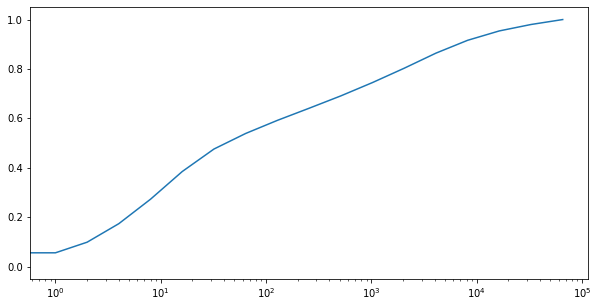

In [26]:
fig, ax = plt.subplots()
ax.plot(bins, pdf)
ax.set_xscale('log')

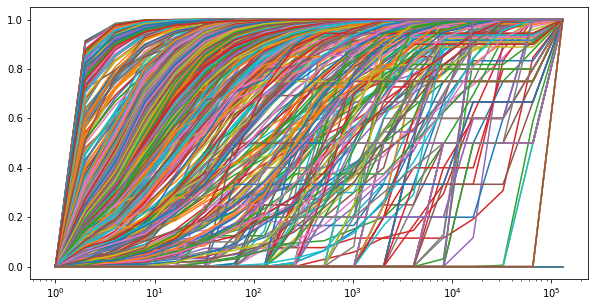

In [27]:
# Per-table reuse_factor of all batches
table_config_path = "/nvme/deep-learning/dlrm_datasets/embedding_bag/2021/fbgemm_t856_bs65536_configs.json"
with open(table_config_path) as f:
    table_configs = json.load(f)["tables"]
fig, ax = plt.subplots()
for t in table_configs:
    ax.plot([2 ** idx for idx in range(len(bins))], [0] + np.cumsum([t["bin_{}".format(idx)] for idx in range(len(bins[:-1]))]).tolist())
    ax.set_xscale('log')

In [28]:
# Per-table per-batch reuse_factor
rf_file = '{}/data/A100/kernel/embedding_lookup_fbgemm_dlrm_datasets_rf.csv'.format(PM_HOME)
with open(rf_file) as f:
    df = pd.read_csv(f).head(6000)

stats = defaultdict(list)
for idx, d in df.iterrows():
    for t_idx, rfs in zip(
        d['num_embeddings'].split('-'),
        d['reuse_factors'].split('_'),
    ):
        stats[int(t_idx)].append([float(x) for x in rfs.split('-')])
stats = sorted(stats.items(), key=(lambda x: -len(x[1])))
# print([(k, len(v), table_configs[k]['num_embeddings'], table_configs[k]['pooling_factor']) for k, v in stats])

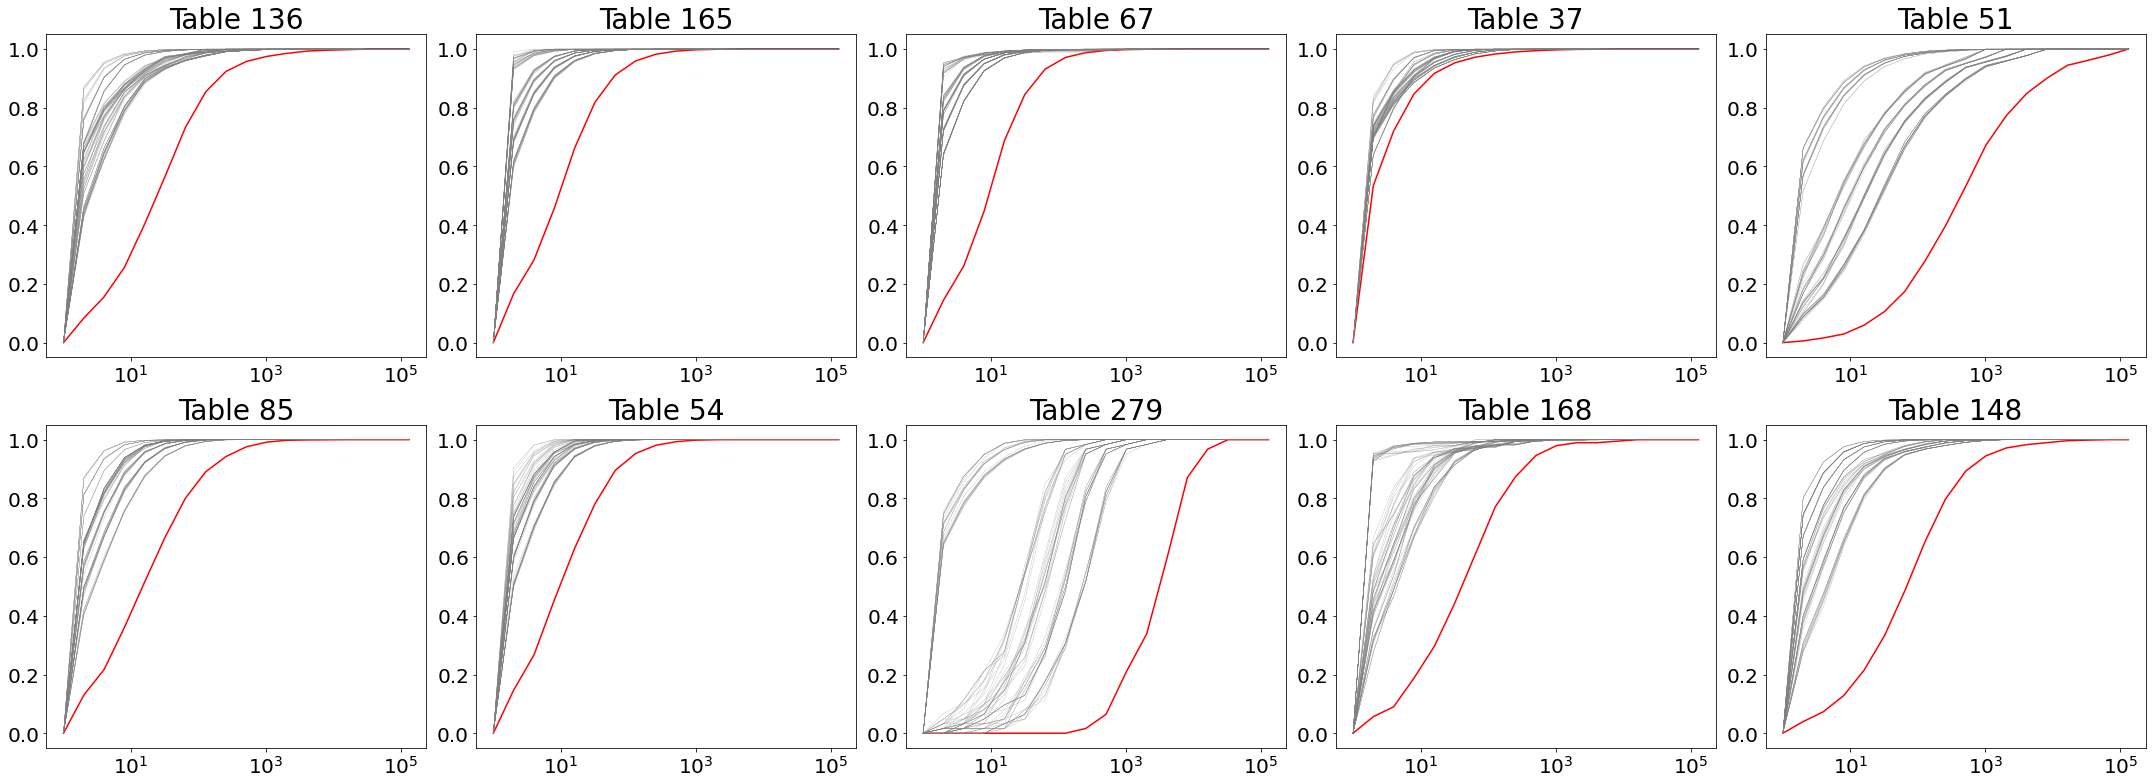

In [29]:
fig, axs =  plt.subplots(2, 5, figsize=(30, 11))
for i in range(10):
    ax = axs[i // 5][i % 5]
    tid = stats[i][0]
    t = table_configs[tid]
    ax.plot(
        [2 ** idx for idx in range(len(bins))],
        [0] + np.cumsum([t["bin_{}".format(idx)] for idx in range(len(bins[:-1]))]).tolist(),
        color='red'
    )
    for s in stats[i][1]:
        ax.plot(
            [2 ** idx for idx in range(len(bins))],
            [0] + np.cumsum(s).tolist(),
            color='gray', linewidth=0.2
        )
    ax.set_title("Table {}".format(tid), fontsize=28)
    ax.set_xscale('log')
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
plt.tight_layout()
plt.savefig('./batch_vs_overall_rf.pdf', bbox_inches='tight')
plt.savefig('./batch_vs_overall_rf.png', bbox_inches='tight')